In [ ]:
%rm -rf /SimCLRv1-keras-tensorflow

!git clone https://github.com/mwdhont/SimCLRv1-keras-tensorflow.git

Cloning into 'SimCLRv1-keras-tensorflow'...
remote: Enumerating objects: 4925, done.
remote: Counting objects: 100% (4925/4925), done.
remote: Compressing objects: 100% (4884/4884), done.
remote: Total 4925 (delta 75), reused 4882 (delta 38), pack-reused 0
Receiving objects: 100% (4925/4925), 46.30 MiB | 33.60 MiB/s, done.
Resolving deltas: 100% (75/75), done.


In [ ]:
%ls
%cd SimCLRv1-keras-tensorflow/
!pip install -r requirements.txt

sample_data/  SimCLRv1-keras-tensorflow/
/content/SimCLRv1-keras-tensorflow
     |████████████████████████████████| 7.7MB 4.9MB/s 
     |████████████████████████████████| 378kB 43.8MB/s 
     |████████████████████████████████| 421.8MB 25kB/s 
     |████████████████████████████████| 26.3MB 116kB/s 
     |████████████████████████████████| 28.2MB 111kB/s 
     |████████████████████████████████| 6.9MB 55.1MB/s 
     |████████████████████████████████| 20.2MB 1.4MB/s 
     |████████████████████████████████| 61kB 8.9MB/s 
     |████████████████████████████████| 51kB 7.3MB/s 
     |████████████████████████████████| 450kB 39.3MB/s 
     |████████████████████████████████| 3.9MB 58.7MB/s 
     |████████████████████████████████| 245kB 54.7MB/s 
     |████████████████████████████████| 61kB 9.7MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7542 sha256=d542b17f8b4e477414cb391f137baca275f799af963b3585d39c76d563ec7034
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a

In [ ]:
import numpy as np
import pickle
import pandas as pd

from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg16 import VGG16 

from evaluate_features import get_features, linear_classifier, tSNE_vis

# Load Dataframe

In [ ]:
df = pd.read_pickle("data/df.pickle")
df.head()

ModuleNotFoundError: ignored

                                filename class_label    class_one_hot
0   data/processed/plastic/plastic80.jpg     plastic  [0, 0, 0, 0, 1]
1  data/processed/plastic/plastic381.jpg     plastic  [0, 0, 0, 0, 1]
2  data/processed/plastic/plastic169.jpg     plastic  [0, 0, 0, 0, 1]
3  data/processed/plastic/plastic354.jpg     plastic  [0, 0, 0, 0, 1]
4  data/processed/plastic/plastic185.jpg     plastic  [0, 0, 0, 0, 1]

In [ ]:
class_labels = ["cardboard", "glass", "metal", "paper", "plastic"]
num_classes = len(df['class_one_hot'][0])

print("# of training instances:", len(df.index), "\n")
for label in class_labels:
    print(f"# of '{label}' training instances: {(df.class_label == label).sum()}")

# of training instances: 2390 

# of 'cardboard' training instances: 403
# of 'glass' training instances: 501
# of 'metal' training instances: 410
# of 'paper' training instances: 594
# of 'plastic' training instances: 482


In [ ]:
df_train, df_val_test = train_test_split(df, test_size=0.30, random_state=42, shuffle=True)
df_val, df_test = train_test_split(df_val_test, test_size=0.50, random_state=42, shuffle=True)

print("# of training instances:", len(df_train.index), "\n")
for label in class_labels:
    print(f"# of '{label}' training instances: {(df_train.class_label == label).sum()}")
    
print()
print("# of validation instances:", len(df_val.index), "\n")
for label in class_labels:
    print(f"# of '{label}' training instances: {(df_val.class_label == label).sum()}")

print()
print("# of test instances:", len(df_test.index), "\n")
for label in class_labels:
    print(f"# of '{label}' training instances: {(df_test.class_label == label).sum()}")
    
dfs = {
    "train": df_train,
    "val": df_val,
    "test": df_test
}

# of training instances: 1673 

# of 'cardboard' training instances: 299
# of 'glass' training instances: 358
# of 'metal' training instances: 286
# of 'paper' training instances: 405
# of 'plastic' training instances: 325

# of validation instances: 358 

# of 'cardboard' training instances: 47
# of 'glass' training instances: 84
# of 'metal' training instances: 51
# of 'paper' training instances: 100
# of 'plastic' training instances: 76

# of test instances: 359 

# of 'cardboard' training instances: 57
# of 'glass' training instances: 59
# of 'metal' training instances: 73
# of 'paper' training instances: 89
# of 'plastic' training instances: 81


In [ ]:
# Img size
size = 80
height_img = size
width_img = size

input_shape = (height_img, width_img, 3)

# Load pretrained VGG16 & Feature evaluation

In [ ]:
params_vgg16 = {'weights': "imagenet", 
                'include_top': False, 
                'input_shape': input_shape, 
                'pooling': None}

# Design model
base_model = VGG16(**params_vgg16)
base_model.summary()

58892288/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 80, 80, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 80, 80, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 80, 80, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 40, 40, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 40, 40, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 40, 40, 128)       147584    
______________________________________________________________

In [ ]:
feat_dim = 2 * 2 * 512

# Build SimCLR-Model

In [ ]:
from DataGeneratorSimCLR import DataGeneratorSimCLR as DataGenerator
from SimCLR import SimCLR

### Properties

In [ ]:
batch_size = 32
# Projection_head
num_layers_ph = 2
feat_dims_ph = [2048, 128]
num_of_unfrozen_layers = 4 #Note: with 1, all weights of the base_model are still frozen (last layer is max_pool)
save_path = 'models/dr'

In [ ]:
SimCLR = SimCLR(
        base_model = base_model,
        input_shape = input_shape,
        batch_size = batch_size,
        feat_dim = feat_dim,
        feat_dims_ph = feat_dims_ph,
        num_of_unfrozen_layers = num_of_unfrozen_layers,
        save_path = save_path
    )

In [ ]:
params_generator = {'batch_size': batch_size,
                    'shuffle' : True,
                    'width':width_img,
                    'height': height_img,
                    'VGG': True
                   }

# Generators
data_train = DataGenerator(df_train.reset_index(drop=True), **params_generator)
data_val = DataGenerator(df_val.reset_index(drop=True), subset = "val", **params_generator) #val keeps the unity values on the same random places ~42
data_test = DataGenerator(df_test.reset_index(drop=True), subset = "test", **params_generator) #test keeps the unity values on the diagonal

In [ ]:
y_predict_test_before = SimCLR.predict(data_test)

## Training SimCLR

In [ ]:
SimCLR.unfreeze_and_train(data_train, 
                          data_val, 
                          num_of_unfrozen_layers = 4, 
                          r = 4, 
                          lr = 1e-6, 
                          epochs = 5)  

Train for 53 steps, validate for 12 steps
Epoch 1/5
52/53 [============================>.] - ETA: 1s - loss: 389.5823
Epoch 00001: val_loss improved from inf to 339.24903, saving model to models/trashnet/SimCLR/SimCLR_07_25_09h_27.h5
53/53 [==============================] - 75s 1s/step - loss: 388.6704 - val_loss: 339.2490
Epoch 2/5
52/53 [============================>.] - ETA: 0s - loss: 296.5550
Epoch 00002: val_loss improved from 339.24903 to 252.58843, saving model to models/trashnet/SimCLR/SimCLR_07_25_09h_27.h5
53/53 [==============================] - 49s 919ms/step - loss: 295.7576 - val_loss: 252.5884
Epoch 3/5
52/53 [============================>.] - ETA: 0s - loss: 216.1633
Epoch 00003: val_loss improved from 252.58843 to 179.10358, saving model to models/trashnet/SimCLR/SimCLR_07_25_09h_27.h5
53/53 [==============================] - 49s 933ms/step - loss: 215.4898 - val_loss: 179.1036
Epoch 4/5
52/53 [============================>.] - ETA: 0s - loss: 149.2019
Epoch 00004: va

In [ ]:
y_predict_test_after = SimCLR.predict(data_test)

## SimCLR-output check

In [ ]:
print(f"Random guess accuracy: {round(1/(2*batch_size),4)}")

print(f"accuracy - test - before: {np.round(np.sum(data_test[0][1] * y_predict_test_before[:batch_size])/(2*batch_size),2)}")
print(f"accuracy - test - after: {np.round(np.sum(data_test[0][1] * y_predict_test_after[:batch_size])/(2*batch_size),2)}")

Random guess accuracy: 0.0156
accuracy - test - before: 0.6
accuracy - test - after: 0.93


In [ ]:
print("y_predict_test_before")
for i in range(min(batch_size, 15)):
    print(np.round(y_predict_test_before[i][i],2), end=" | ")
print("\n")    
print("y_predict_test_after")
for i in range(min(batch_size, 15)):
    print(np.round(y_predict_test_after[i][i],2), end=" | ")
print("\n") 
print("y_predict_test_after - Second diagonal")
for i in range(min(batch_size, 15)):
    print(np.round(y_predict_test_after[i + 2 * batch_size][i],2), end=" | ")
print("\n")    

y_predict_test_before
0.85 | 0.52 | 0.51 | 0.23 | 0.81 | 0.78 | 0.81 | 0.73 | 0.56 | 0.58 | 0.62 | 0.81 | 0.36 | 0.88 | 0.74 | 

y_predict_test_after
0.99 | 0.99 | 0.97 | 0.99 | 0.99 | 0.99 | 0.99 | 0.93 | 0.99 | 0.99 | 0.97 | 0.95 | 0.05 | 0.66 | 0.98 | 

y_predict_test_after - Second diagonal
0.97 | 0.99 | 0.98 | 0.95 | 0.98 | 0.99 | 0.96 | 0.72 | 0.98 | 0.96 | 0.74 | 0.99 | 0.98 | 0.92 | 0.89 | 



## Feature Evaluation

### Logistic Regression

In [ ]:
base_model = SimCLR.base_model

In [ ]:
features_train, y_train, feats = get_features(base_model, df_train, class_labels)
features_test, y_test, feats = get_features(base_model, df_test, class_labels)
np.count_nonzero(features_train[0])

1103

In [ ]:
# Training logistic regression classifier on 3 fractions of the data
# Optimal regularization is determined from a 5-fold cross-validation
fractions = [1.0, 0.2, 0.05]
for fraction in fractions:
    print(f"    ==== {fraction * 100}% of the training data used ==== \n")
    linear_classifier(features_train, y_train, features_test, y_test, class_labels, fraction = fraction)

    ==== 100.0% of the training data used ==== 

Accuracy on test: 0.83 

              precision    recall  f1-score   support

   cardboard       0.90      0.82      0.86        57
       glass       0.80      0.80      0.80        59
       metal       0.79      0.90      0.84        73
       paper       0.84      0.89      0.86        89
     plastic       0.83      0.72      0.77        81

    accuracy                           0.83       359
   macro avg       0.83      0.83      0.83       359
weighted avg       0.83      0.83      0.83       359

    ==== 20.0% of the training data used ==== 

Accuracy on test: 0.82 

              precision    recall  f1-score   support

   cardboard       0.92      0.84      0.88        57
       glass       0.77      0.80      0.78        59
       metal       0.79      0.85      0.82        73
       paper       0.81      0.89      0.85        89
     plastic       0.83      0.73      0.78        81

    accuracy                          

### Fine tuned model

In [ ]:
batch_size_classifier = 32
params_generator_classifier = {'max_width':width_img,
                            'max_height': height_img,
                            'num_classes': num_classes,
                            'VGG': True
                            }
params_training_classifier = {'1.0':{
                                "reg_dense" : 0.005,
                                "reg_out" : 0.005,
                                "nums_of_unfrozen_layers" : [5, 5, 6, 7],
                                "lrs" : [1e-3, 1e-4, 5e-5, 5e-5],
                                "epochs" : [5, 5, 15, 10]
                                },
                              '0.2':{
                                "reg_dense" : 0.075,
                                "reg_out" : 0.01,
                                "nums_of_unfrozen_layers" : [5, 5, 6, 7],
                                "lrs" : [1e-3, 1e-4, 5e-5, 5e-5],
                                "epochs" : [5, 5, 20, 15]
                              },
                              '0.05':{
                                "reg_dense" : 0.01,
                                "reg_out" : 0.02,
                                "nums_of_unfrozen_layers" : [5, 5, 6, 7],
                                "lrs" : [1e-3, 1e-4, 5e-5, 1e-5],
                                "epochs" : [5, 5, 20, 15]
                              }                              
                            }

In [ ]:
for fraction in fractions:    
    print(f"    ==== {fraction * 100}% of the training data used ==== \n")
    SimCLR.train_NL_and_evaluate(dfs = dfs,
                                batch_size = batch_size_classifier,
                                params_generator = params_generator_classifier,
                                fraction = fraction,
                                class_labels = class_labels,
                                reg_dense = params_training_classifier[str(fraction)]["reg_dense"],
                                reg_out = params_training_classifier[str(fraction)]["reg_out"],
                                nums_of_unfrozen_layers = params_training_classifier[str(fraction)]["nums_of_unfrozen_layers"],
                                lrs = params_training_classifier[str(fraction)]["lrs"],
                                epochs = params_training_classifier[str(fraction)]["epochs"],
                                verbose_epoch = 0,
                                verbose_cycle = 0
                                )

    ==== 100.0% of the training data used ==== 

Best result from attempt 3
              precision    recall  f1-score   support

   cardboard       0.96      0.91      0.94        57
       glass       0.85      0.88      0.87        59
       metal       0.81      0.89      0.85        73
       paper       0.90      0.94      0.92        89
     plastic       0.92      0.80      0.86        81

    accuracy                           0.89       359
   macro avg       0.89      0.89      0.89       359
weighted avg       0.89      0.89      0.89       359

    ==== 20.0% of the training data used ==== 

Best result from attempt 1
              precision    recall  f1-score   support

   cardboard       0.90      0.95      0.92        57
       glass       0.83      0.83      0.83        59
       metal       0.81      0.86      0.83        73
       paper       0.92      0.92      0.92        89
     plastic       0.90      0.81      0.86        81

    accuracy                      

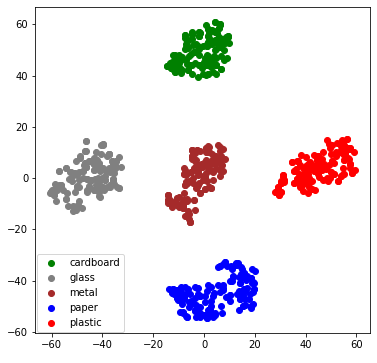

In [ ]:
tSNE_vis(df_train, features_train, class_labels)